In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH3smpE7Zm5agwXZyrIPqSlzEU7yaHD-3OoUwbB-6h5AALQt0q1CW4
Mounted at /content/drive


In [3]:
%cd drive/My Drive

/content/drive/My Drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
from tensorflow.keras import backend as K
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [59]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

features = train_img/255.0
labels = train_digit.to_numpy()

X_test = test_img/255.0

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

validation_split = 0.1

def add_array(x1,x2):
    
    array_seq = []
    
    # seq_cols
    array_seq.append(x1)
    
    # meta_cols
    array_seq.append(x2)
    
    return array_seq

column_number = {}

for i in range(26):
  column_number[chr(65+i)] = i

def to_number(x, dic):
    return dic[x]

train_letter = train_letter.apply(lambda x: to_number(x, column_number))
train_letter = to_categorical(train_letter,num_classes=26)

X_train, X_val, letter_train, letter_val ,  y_train, y_val = train_test_split(features, train_letter, labels, test_size = validation_split, random_state = 100)

In [60]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 3,
        height_shift_range = 3,
        zoom_range=0.2,
        )

train_qul = add_array(X_train,letter_train)
val_qul = add_array(X_val,letter_val)
flow1=train_datagen.flow(train_qul,y_train,batch_size=16,seed=2020) 
test_datagen = ImageDataGenerator()
flow2=test_datagen.flow(val_qul,y_val,batch_size=16,seed=2020) 



In [61]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [72]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))

    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.BatchNormalization()(img_input)
    conv_1 = layers.Activation('mish')(conv_1)
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',)(conv_1) 
    
    conv_2_1 = layers.BatchNormalization()(conv_1)
    conv_2_1 = layers.Activation('mish')(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    conv_2_1 = layers.Dropout(rate = 0.3)(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('mish')(add_2_1)
    
    conv_2_2 = layers.BatchNormalization()(out_2_1)
    conv_2_2 = layers.Activation('mish')(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    conv_2_2 = layers.Dropout(rate = 0.3)(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('mish')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)

    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('mish')(add_3_1)
    
    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.BatchNormalization()(conv_4_0)
    conv_4_1 = layers.Activation('mish')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('mish')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = layers.Flatten()(pool_4)
    img_features = layers.BatchNormalization()(img_features)
    img_features = layers.Dense(1024, activation = 'mish')(img_features)
    img_features1 = layers.Dropout(rate = 0.3)(img_features)

    alpha_input = layers.Input(shape =(26,))
    alpha_features = layers.Dense(26, activation = 'mish')(alpha_input)
    
    merges = layers.Concatenate()([img_features1, alpha_features])

    all_features = layers.Dense(512, activation = 'mish')(merges)
    all_features = layers.Dense(512, activation = 'mish')(all_features)
    all_features = layers.BatchNormalization()(all_features)
    all_features = layers.Dropout(rate = 0.2)(all_features)
    all_features = layers.Dense(256, activation = 'mish')(all_features)
    all_features = layers.Dense(256, activation = 'mish')(all_features)
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(all_features)
    
    model = tf.keras.Model(inputs = [img_input,alpha_input], outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model


def train_model_v1(model, train, test,  epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 3, min_lr = 3e-5)
    
    history = model.fit(train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = test, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train,  epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 3, min_lr = 3e-5)
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [73]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0003)
    model_list.append(model)

In [74]:
model_list[0].summary()

Model: "functional_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_460 (BatchN (None, 28, 28, 1)    4           input_121[0][0]                  
__________________________________________________________________________________________________
activation_760 (Activation)     (None, 28, 28, 1)    0           batch_normalization_460[0][0]    
__________________________________________________________________________________________________
conv2d_930 (Conv2D)             (None, 28, 28, 128)  1280        activation_760[0][0]             
_____________________________________________________________________________________

***************Trainig_my_model_0*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1651 - accuracy: 0.2328 - val_loss: 4.1070 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 2s 17ms/step - loss: 1.8987 - accuracy: 0.3223 - val_loss: 3.9491 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7744 - accuracy: 0.3614 - val_loss: 7.2384 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6267 - accuracy: 0.4411 - val_loss: 4.4153 - val_accuracy: 0.1122
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5575 - accuracy: 0.4531 - val_loss: 2.5313 - val_accuracy: 0.2976
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4228 - accuracy: 0.4976 - val_loss: 1.1185 - val_accuracy: 0.6195
Epoch 7/200
116/116 [==============================] - 2s 16ms/step - loss: 1.3916 - 

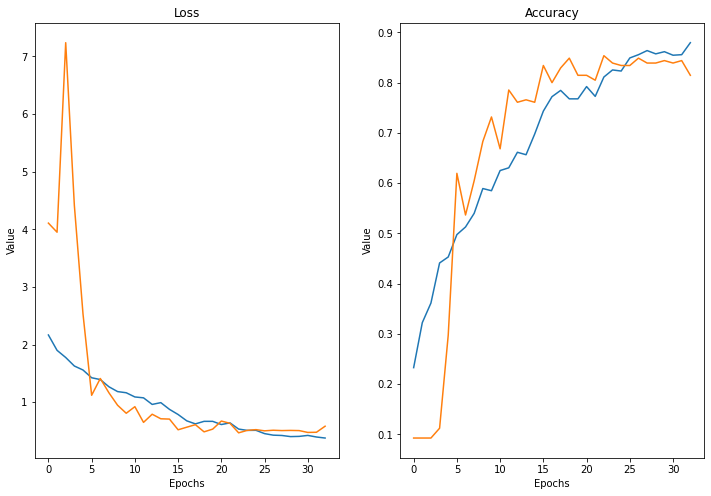

***************Trainig_my_model_1*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1290 - accuracy: 0.2528 - val_loss: 5.0496 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 2s 17ms/step - loss: 1.9233 - accuracy: 0.3272 - val_loss: 4.5721 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 17ms/step - loss: 1.7504 - accuracy: 0.3798 - val_loss: 6.0991 - val_accuracy: 0.1024
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6466 - accuracy: 0.4270 - val_loss: 4.5881 - val_accuracy: 0.1220
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4974 - accuracy: 0.4574 - val_loss: 2.3712 - val_accuracy: 0.3659
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4682 - accuracy: 0.4938 - val_loss: 1.2617 - val_accuracy: 0.5463
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3258 - 

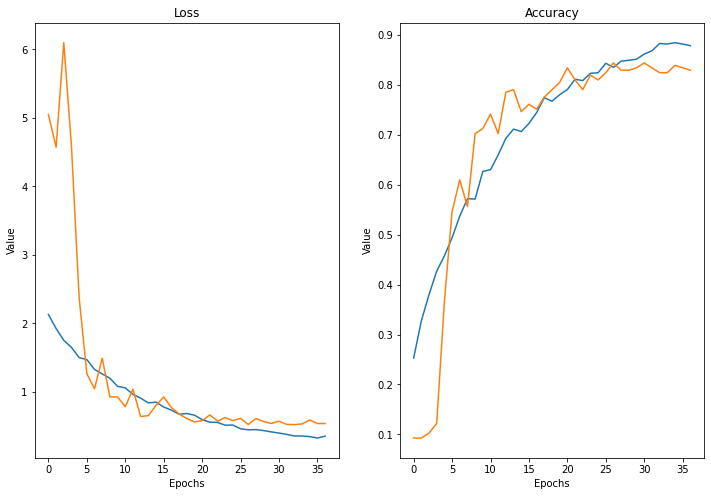

***************Trainig_my_model_2*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1528 - accuracy: 0.2442 - val_loss: 4.2384 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.8935 - accuracy: 0.3326 - val_loss: 4.1402 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7652 - accuracy: 0.3733 - val_loss: 6.7441 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6494 - accuracy: 0.4151 - val_loss: 5.1071 - val_accuracy: 0.1073
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5403 - accuracy: 0.4645 - val_loss: 2.6243 - val_accuracy: 0.2195
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4252 - accuracy: 0.5019 - val_loss: 1.7129 - val_accuracy: 0.4585
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3595 - 

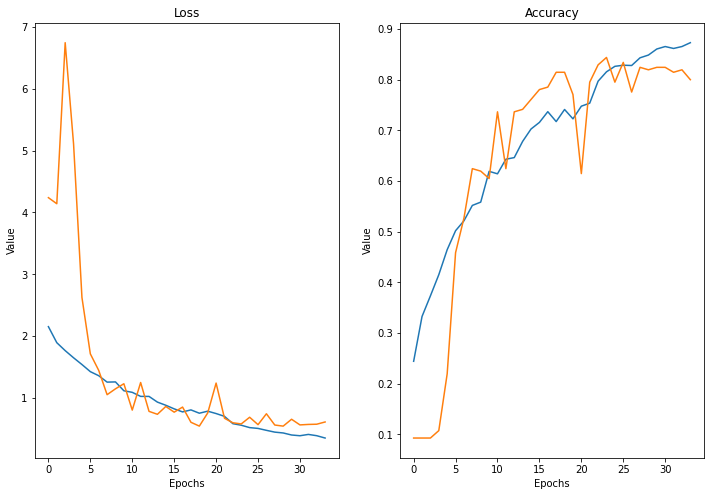

***************Trainig_my_model_3*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1716 - accuracy: 0.2198 - val_loss: 3.1612 - val_accuracy: 0.1024
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.9423 - accuracy: 0.3011 - val_loss: 3.5847 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7977 - accuracy: 0.3500 - val_loss: 8.3283 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6810 - accuracy: 0.3993 - val_loss: 4.4853 - val_accuracy: 0.1317
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5611 - accuracy: 0.4449 - val_loss: 1.7588 - val_accuracy: 0.4098
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4750 - accuracy: 0.4704 - val_loss: 1.3758 - val_accuracy: 0.5024
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4107 - 

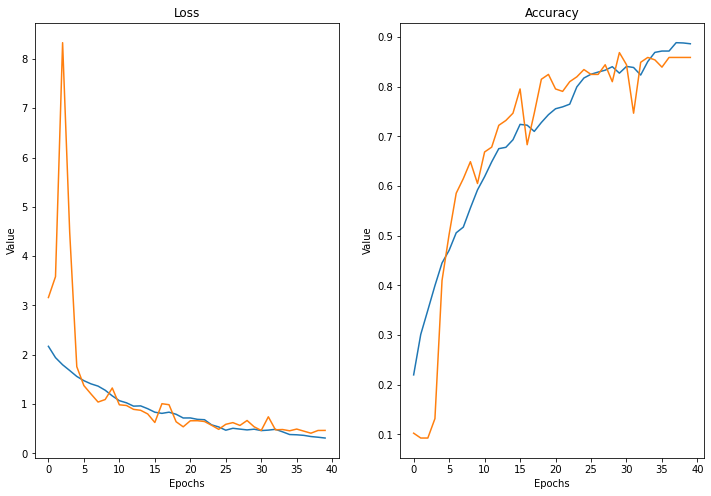

***************Trainig_my_model_4*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1865 - accuracy: 0.2176 - val_loss: 2.9088 - val_accuracy: 0.1512
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.8941 - accuracy: 0.3283 - val_loss: 3.3012 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7846 - accuracy: 0.3608 - val_loss: 7.4170 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 16ms/step - loss: 1.6444 - accuracy: 0.4097 - val_loss: 5.3568 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4561 - accuracy: 0.4824 - val_loss: 2.1357 - val_accuracy: 0.2732
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3075 - accuracy: 0.5410 - val_loss: 1.6422 - val_accuracy: 0.4829
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.2727 - 

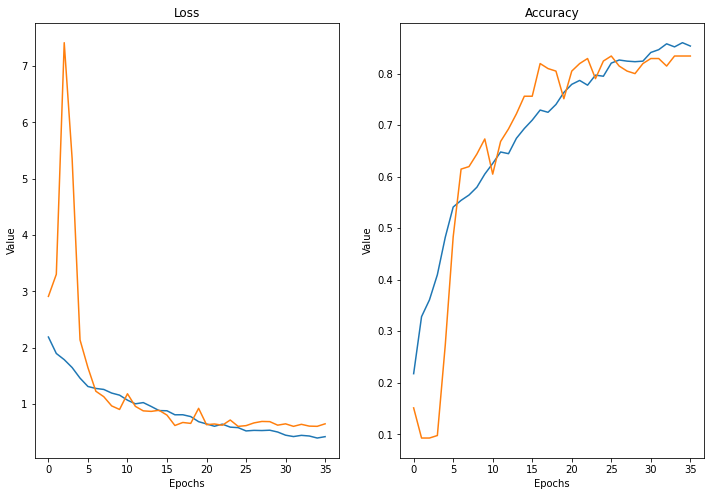

***************Trainig_my_model_5*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1690 - accuracy: 0.2322 - val_loss: 2.5978 - val_accuracy: 0.1024
Epoch 2/200
116/116 [==============================] - 2s 17ms/step - loss: 1.8935 - accuracy: 0.3456 - val_loss: 3.5010 - val_accuracy: 0.1024
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7896 - accuracy: 0.3402 - val_loss: 5.3017 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6754 - accuracy: 0.3956 - val_loss: 3.7024 - val_accuracy: 0.1171
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5381 - accuracy: 0.4563 - val_loss: 3.0418 - val_accuracy: 0.2195
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4095 - accuracy: 0.5122 - val_loss: 1.1677 - val_accuracy: 0.5902
Epoch 7/200
116/116 [==============================] - 2s 16ms/step - loss: 1.4065 - 

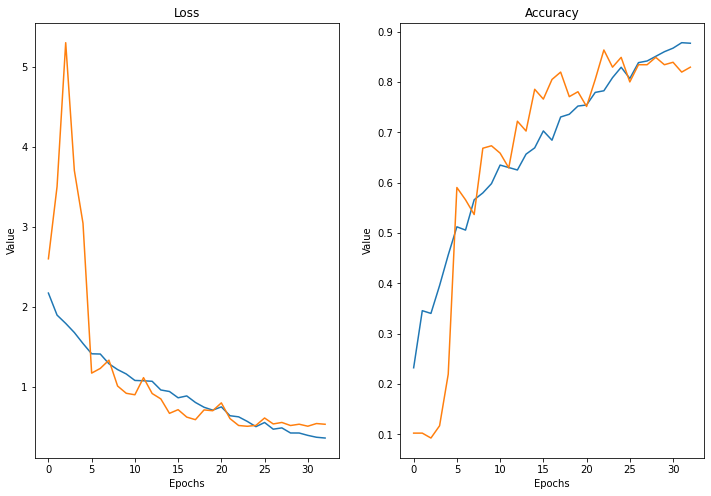

***************Trainig_my_model_6*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1527 - accuracy: 0.2398 - val_loss: 2.6035 - val_accuracy: 0.1171
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.8955 - accuracy: 0.3304 - val_loss: 6.2607 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7749 - accuracy: 0.3652 - val_loss: 7.7813 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6606 - accuracy: 0.4200 - val_loss: 3.0674 - val_accuracy: 0.1561
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5454 - accuracy: 0.4590 - val_loss: 1.9617 - val_accuracy: 0.3610
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4637 - accuracy: 0.4965 - val_loss: 1.4241 - val_accuracy: 0.5171
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3814 - 

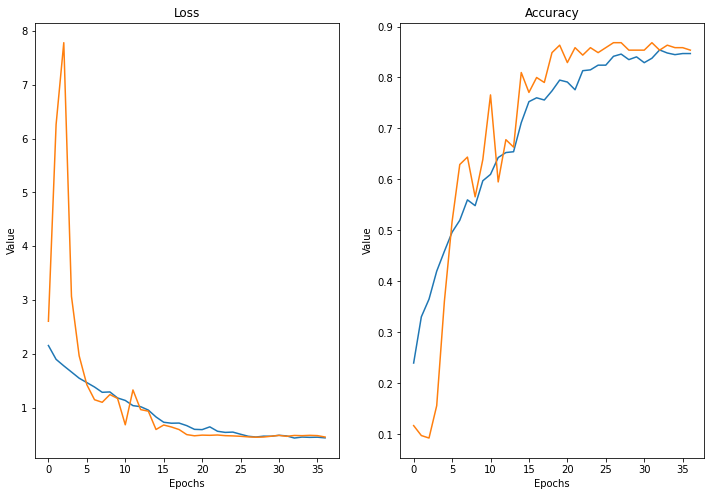

***************Trainig_my_model_7*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1383 - accuracy: 0.2458 - val_loss: 2.8488 - val_accuracy: 0.0732
Epoch 2/200
116/116 [==============================] - 2s 17ms/step - loss: 1.9093 - accuracy: 0.3234 - val_loss: 2.9978 - val_accuracy: 0.1073
Epoch 3/200
116/116 [==============================] - 2s 17ms/step - loss: 1.7775 - accuracy: 0.3597 - val_loss: 3.6194 - val_accuracy: 0.1024
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6829 - accuracy: 0.4015 - val_loss: 3.2644 - val_accuracy: 0.1659
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5469 - accuracy: 0.4449 - val_loss: 1.5941 - val_accuracy: 0.4976
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4238 - accuracy: 0.4916 - val_loss: 1.7358 - val_accuracy: 0.5024
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3679 - 

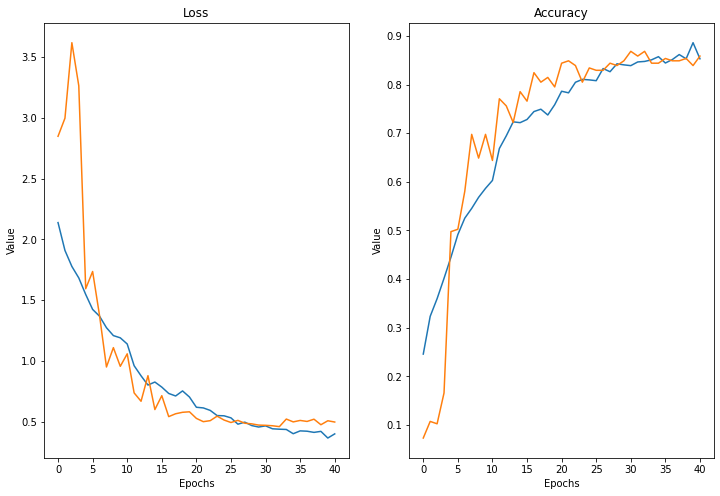

***************Trainig_my_model_8*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1798 - accuracy: 0.2263 - val_loss: 2.7866 - val_accuracy: 0.0976
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.9072 - accuracy: 0.3321 - val_loss: 4.5465 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 2s 16ms/step - loss: 1.7595 - accuracy: 0.3668 - val_loss: 7.4155 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 16ms/step - loss: 1.6907 - accuracy: 0.3934 - val_loss: 5.3868 - val_accuracy: 0.0927
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4685 - accuracy: 0.4769 - val_loss: 2.1812 - val_accuracy: 0.2878
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3882 - accuracy: 0.5041 - val_loss: 1.4297 - val_accuracy: 0.4976
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.3136 - 

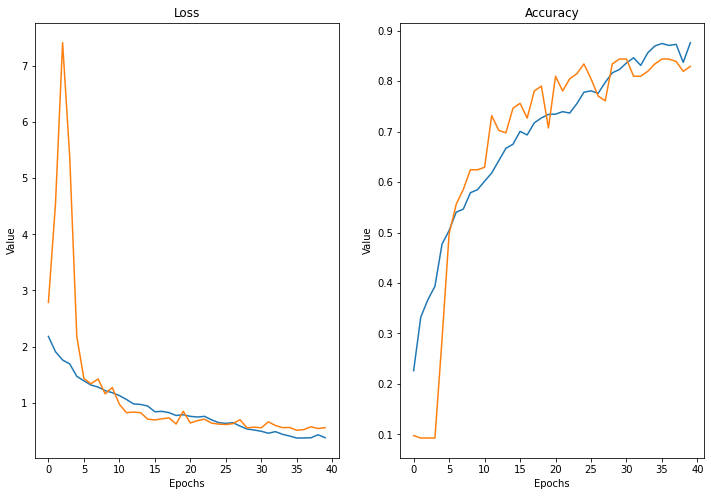

***************Trainig_my_model_9*****************
Epoch 1/200
116/116 [==============================] - 2s 20ms/step - loss: 2.1864 - accuracy: 0.2273 - val_loss: 3.5439 - val_accuracy: 0.1024
Epoch 2/200
116/116 [==============================] - 2s 16ms/step - loss: 1.9099 - accuracy: 0.3212 - val_loss: 2.9729 - val_accuracy: 0.1024
Epoch 3/200
116/116 [==============================] - 2s 17ms/step - loss: 1.8100 - accuracy: 0.3494 - val_loss: 3.1728 - val_accuracy: 0.1073
Epoch 4/200
116/116 [==============================] - 2s 17ms/step - loss: 1.7219 - accuracy: 0.3776 - val_loss: 2.3809 - val_accuracy: 0.2488
Epoch 5/200
116/116 [==============================] - 2s 17ms/step - loss: 1.6068 - accuracy: 0.4319 - val_loss: 2.2921 - val_accuracy: 0.3171
Epoch 6/200
116/116 [==============================] - 2s 17ms/step - loss: 1.5316 - accuracy: 0.4514 - val_loss: 1.4269 - val_accuracy: 0.5073
Epoch 7/200
116/116 [==============================] - 2s 17ms/step - loss: 1.4435 - 

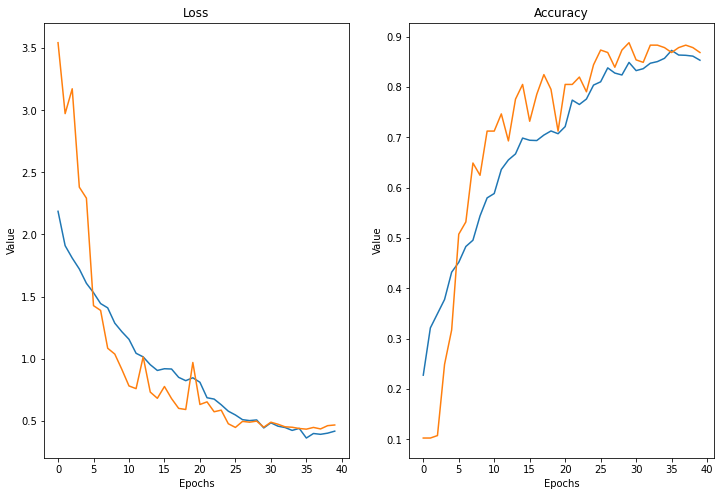

In [75]:
epochs = 200
batch_size = 16
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], flow1, flow2, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [76]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(flow2)
    result_list.append(result)

************************Evaluating_my_model_0************************
13/13 [==============================] - 0s 6ms/step - loss: 0.4669 - accuracy: 0.8537
************************Evaluating_my_model_1************************
13/13 [==============================] - 0s 6ms/step - loss: 0.5205 - accuracy: 0.8439
************************Evaluating_my_model_2************************
13/13 [==============================] - 0s 6ms/step - loss: 0.5799 - accuracy: 0.8439
************************Evaluating_my_model_3************************
13/13 [==============================] - 0s 6ms/step - loss: 0.5395 - accuracy: 0.8683
************************Evaluating_my_model_4************************
13/13 [==============================] - 0s 6ms/step - loss: 0.6119 - accuracy: 0.8341
************************Evaluating_my_model_5************************
13/13 [==============================] - 0s 6ms/step - loss: 0.5123 - accuracy: 0.8634
************************Evaluating_my_model_6*************

In [ ]:
test_letter = test_letter.apply(lambda x: to_number(x, column_number))
test_letter = to_categorical(test_letter,num_classes=26)
test_qul = add_array(X_test,test_letter)

In [79]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(test_qul)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [80]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [81]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,8,5,9,8,3,5,9,5,5,9,5
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,0,8,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,6,3,8,8,6,1,6,3,6,8,6


In [82]:
submission = pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,5
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,6


In [83]:
for i in range(len(model_list)):
  tf.keras.models.save_model(model_list[i],'ckpt1/model{}'.format(i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ckpt1/model0/assets
INFO:tensorflow:Assets written to: ckpt1/model1/assets
INFO:tensorflow:Assets written to: ckpt1/model2/assets
INFO:tensorflow:Assets written to: ckpt1/model3/assets
INFO:tensorflow:Assets written to: ckpt1/model4/assets
INFO:tensorflow:Assets written to: ckpt1/model5/assets
INFO:tensorflow:Assets written to: ckpt1/model6/assets
INFO:tensorflow:Assets written to: ckpt1/model7/assets
INFO:tensorflow:Assets written to: ckpt1/model8/assets
INFO:tensorflow:Assets written to: ckpt1/model9/assets


In [89]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('ckpt1/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(flow2, epochs = 8, batch_size = 1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Epoch 1/8
13/13 [==============================] - 0s 15ms/step - loss: 0.6654 - accuracy: 0.7951
Epoch 2/8
13/13 [==============================] - 0s 14ms/step - loss: 0.3390 - accuracy: 0.9073
Epoch 3/8
13/13 [==============================] - 0s 14ms/step - loss: 0.3090 - accuracy: 0.8976
Epoch 4/8
13/13 [==============================] - 0s 14ms/step - loss: 0.2256 - accuracy: 0.9366
Epoch 5/8
13/13 [==============================] - 0s 14ms/step - loss: 0.1869 - accuracy: 0.9366
Epoch 6/8
13/13 [==============================] - 0s 14ms/step - loss: 0.1719 - accuracy: 0.9512
Epoch 7/8
13/13 [==============================] - 0s 14ms/step - loss: 0.1690 - accuracy: 0.9512
Epoch 8/8
13/13 [==============================] - 0s 14ms/step - loss: 0.1607 - accuracy: 0.9610
************************Loading_my_model_1************************
***********

In [90]:
re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(test_qul)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [92]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [94]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,5,9,9,3,5,9,8,5,5,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,9,4,9,4,4,4,4,9,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,3,3,1,6,1,1,1,1,6,1,1


In [96]:
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline1.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,1


# 추가한 것

- 단순하게 알파벳을 feature로 추가한 다음 모델 안에서 concatenate를 이용해 이미지로 나온 것과 합침. 결과는 비슷....